### NLP (Natural Language Processing) with PEFT (Parameter Efficient Fine-Tuning) and LoRA (Low-Rank Adaptation) for Less-Toxic Summarization


**Flujo de trabajo del proyecto:**
* **Configuración:** Importar las bibliotecas necesarias y definir los parámetros del proyecto.
* **Exploración del conjunto de datos:** Descubrir el conjunto de datos DialogSum.
* **Probar la inferencia de cero disparos del modelo:** Inicialmente, probar el modelo FLAN-T5 para la inferencia de cero disparos en tareas de resumen de diálogos para establecer un rendimiento de referencia.
* **Preprocesar el diálogo y el resumen del conjunto de datos:** Preprocesar el diálogo y su resumen correspondiente del conjunto de datos para prepararlo para el entrenamiento.
* **Realizar un ajuste fino eficiente de parámetros (PEFT):** Implementar el ajuste fino eficiente de parámetros (PEFT), un enfoque de ajuste fino más eficiente que puede reducir significativamente el tiempo de entrenamiento mientras se mantiene el rendimiento.
* **Evaluación:**
  * Realizar una evaluación humana para medir el resultado del modelo en términos de legibilidad y coherencia. Esto puede implicar que los anotadores clasifiquen los resúmenes generados por calidad.
  * Utilizar las métricas ROUGE para evaluar la calidad de los resúmenes generados. ROUGE mide la superposición entre los resúmenes generados y las referencias escritas por humanos.

**Datos**

DialogSum es un conjunto de datos de resumen de diálogos a gran escala, que consta de 13 460 diálogos (más 100 datos de reserva para la generación de temas) con resúmenes y temas correspondientes etiquetados manualmente.

[Dialogsum](https://huggingface.co/datasets/knkarthick/dialogsum?row=0)

## <b>1 <span style='color:#78D118'>|</span> Introducción</b>

Este proyecto explora las capacidades de los modelos de lenguaje grandes (LLM), haciendo especial hincapié en el uso del ajuste fino con eficiencia de parámetros (PEFT) para crear resúmenes de diálogos con toxicidad reducida. Ajustaremos un modelo FLAN-T5 para generar contenido menos tóxico utilizando el modelo de recompensa por discurso de odio de Meta AI. Este modelo de recompensa es un clasificador binario que predice si un texto determinado es “no odioso” o “odio”. Utilizaremos el Proximal Policy Optimization (PPO) para ajustar el modelo y reducir su toxicidad.

Nuestro objetivo principal es mejorar la calidad de los resúmenes de diálogos y, al mismo tiempo, minimizar la toxicidad. Para lograrlo, aplicamos el Proximal Policy Optimization (PPO) para el ajuste fino, con el objetivo de mitigar la salida tóxica del modelo. Además, mostraremos las ventajas del ajuste fino con eficiencia de parámetros (PEFT), demostrando que sus beneficios superan cualquier posible compensación menor en el rendimiento.



**NOTA**: Este es un ejemplo y no utilizamos la totalidad de los datos utilizados.

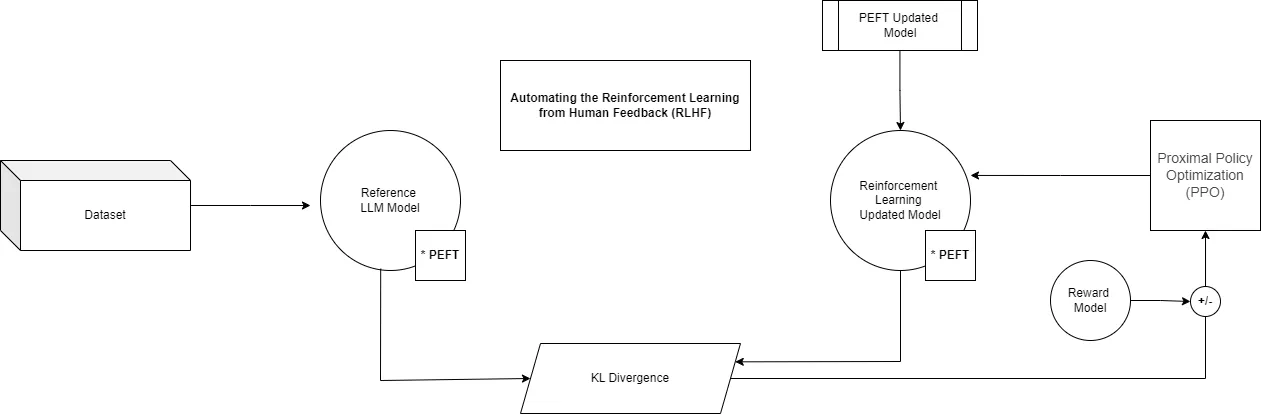!

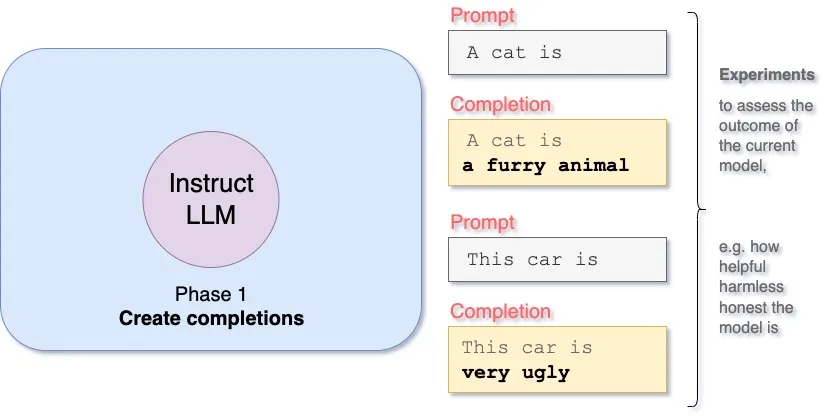


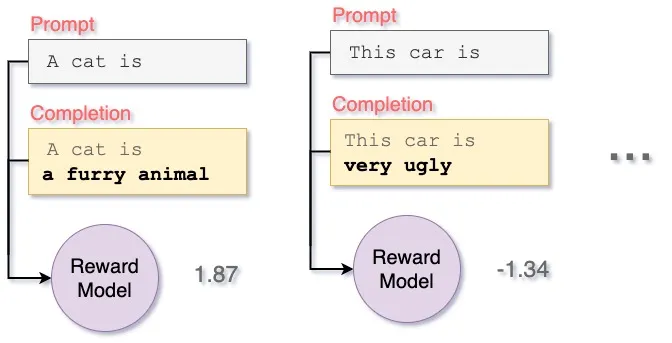

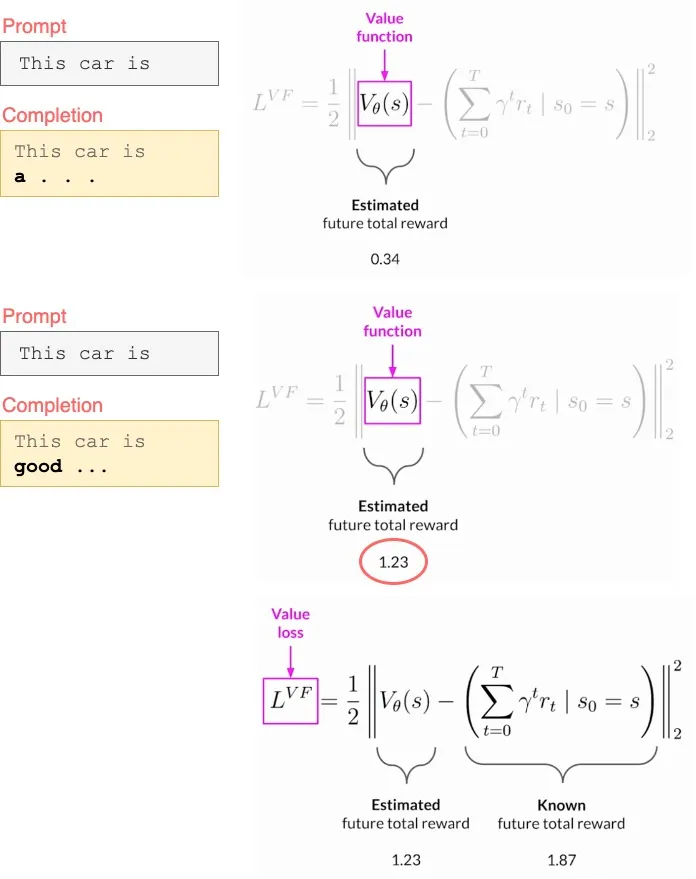

In [1]:
%pip install --upgrade pip
%pip install torch 
%pip install torchdata

%pip install transformers
%pip install evaluate
%pip install rouge_score
%pip install peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 37.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a34f06d4d0ae411ea6f51fa2ef15228b9e622691e1d6d180ba19f50a73184450
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart 

In [ ]:
#install the libraries
#%pip install --upgrade pip
#%pip install --disable-pip-version-check \
    #torch==1.13.1 \
    #torchdata==0.5.1 --quiet

#%pip install \
    #transformers==4.27.2 \
    #evaluate==0.4.0 \
    #rouge_score==0.1.2 \
    #peft==0.3.0 --quiet

# Installing the Reinforcement Learning library directly from github.
#%pip install git+https://github.com/lvwerra/trl.git@25fa1bd  
#!pip install trl==0.4.4 #for PPO
    
#!pip install loralib==0.1.1 

# Installing the Reinforcement Learning library directly from github.
#%pip install git+https://github.com/lvwerra/trl.git@25fa1bd


In [2]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install trl==0.11.3

Note: you may need to restart the kernel to use updated packages.


In [4]:
#load the libs
#,GenerationConfig va en transformer

from datasets import  load_dataset, Dataset
from transformers import pipeline, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, GenerationConfig,Trainer
#trl: Transformer Reinforcement Learning Library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import time
import evaluate
import pandas as pd
import numpy as np


#tqdm library makes the loops show a smart progress meter
from tqdm import tqdm 
tqdm.pandas()

## <b>2 <span style='color:#78D118'>|</span> Descarga de datos</b>

Aquí, utilizaremos el modelo T5 como base entrenada previamente y utilizaremos el tokenizador correspondiente. Puede utilizar un modelo entrenado previamente diferente (y el tokenizador correspondiente) cambiando el nombre del modelo a continuación por un modelo diferente en Hugging Face Hub, o utilizar un modelo personalizado/entrenar un tokenizador desde cero en su propio conjunto de datos. Tenga en cuenta que necesitará muchos más datos y cálculos para entrenar un buen modelo desde cero.

T5 is available in multiple sizes, including: T5 Small, T5 Base, T5 Large, T5 3B, T5 11B

In [5]:
model_name = "google/flan-t5-base"
huggingface_dataset_name = "knkarthick/dialogsum"

# Load the dataset
dataset_original = load_dataset(huggingface_dataset_name)

# Check the dataset
print(dataset_original)

README.md:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/442k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


## <b>3 <span style='color:#78D118'>|</span> Metodos</b>

In [7]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

# <b>4<span style='color:#78D118'>|</span> Tokenizando la información</b>


El siguiente paso implica el preprocesamiento del conjunto de datos. Seleccionaremos un subconjunto de los datos, filtraremos los diálogos a una longitud específica para garantizar la legibilidad manteniendo al mismo tiempo un contenido significativo y luego integraremos cada diálogo con una instrucción antes de convertir en tokens las indicaciones. Los identificadores de token resultantes se almacenarán en el campo `input_ids`, mientras que las indicaciones decodificadas se guardarán en el campo `query`.

Para agilizar este proceso, es recomendable crear una función llamada `build_dataset`. Esta función se puede definir de la siguiente manera:

In [8]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length, 
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.
        
    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """
    
    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")
    
    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name) #, device_map="auto"
    
    def tokenize(sample):
        
        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)
        
        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")
    
    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200, 
                        input_max_text_length=1000)

print(dataset)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/10022 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 8017
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic', 'input_ids', 'query'],
        num_rows: 2005
    })
})


# <b>5 <span style='color:#78D118'>|</span>  Modelo FLAN-T5 optimizado con instrucciones de resumen</b>

## <b>5.1 <span style='color:#78D118'>|</span>  Mejora del modelo FLAN-T5 optimizado con un adaptador de resumen</b>

Estamos mejorando el modelo FLAN-T5 original agregando un adaptador de resumen. Este adaptador está diseñado para mejorar el rendimiento del modelo en tareas de resumen.

Comenzamos configurando el adaptador utilizando los siguientes parámetros:
- `r`: Rank, which is set to 32.
- `lora_alpha`: LORA alpha value, set to 32.
- `target_modules`: We specify the target modules as ["q", "v"].
- `lora_dropout`: Dropout rate for LORA, set to 0.05.
- `bias`: We use "none" as the bias configuration.
- `task_type`: The task type is set to SEQ_2_SEQ_LM, which is suitable for FLAN-T5.

A continuación, cargamos el modelo FLAN-T5 previamente entrenado y creamos una instancia de AutoModelForSeq2SeqLM con el nombre de modelo y el tipo de datos especificados (torch_dtype).

También creamos un PeftModel incorporando el modelo cargado previamente.
Además, proporcionamos la configuración de LORA, el tipo de datos torch, el mapeo del dispositivo y especificamos que el modelo se puede entrenar.

In [9]:
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, 
                                              torch_dtype=torch.bfloat16)

peft_model = PeftModel.from_pretrained(model, 
                                       'z7ye/peft-dialogue-summary-checkpoint', 
                                       lora_config=lora_config,
                                       torch_dtype=torch.bfloat16, 
                                       is_trainable=True) #device_map="auto", 

print(f'PEFT model parameters to be updated:\n{print_number_of_trainable_model_parameters(peft_model)}\n')


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

PEFT model parameters to be updated:

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%



## <b>5.2 <span style='color:#78D118'>|</span> Mejorar el resumen de LLM con aprendizaje de refuerzo con POO</b>

Ahora, estamos en el proceso de preparación para el ajuste fino del modelo de lenguaje (LLM) mediante aprendizaje por refuerzo (RL). Aunque se trata de una explicación más detallada del RL, nuestro enfoque actual está en la configuración del modelo de optimización de política proximal (PPO).

Este modelo PPO recibirá el modelo PEFT ajustado por instrucción como entrada y se utilizará para optimizar la política de RL de acuerdo con el modelo de recompensa.

In [10]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,                                                               
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

PPO model parameters to be updated (ValueHead + 769 params):

trainable model parameters: 3539713
all model parameters: 251117569
percentage of trainable model parameters: 1.41%

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [11]:
ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

Reference model parameters to be updated:

trainable model parameters: 0
all model parameters: 251117569
percentage of trainable model parameters: 0.00%



# <b>6<span style='color:#78D118'>|</span> Construcción de un modelo de recompensa para el aprendizaje por refuerzo</b>

El aprendizaje por refuerzo (RL) es una rama fundamental del aprendizaje automático en la que los agentes toman decisiones dentro de un entorno para maximizar sus recompensas acumuladas. El comportamiento de estos agentes está regido por una política de toma de decisiones y el objetivo fundamental del RL es que el agente adquiera una política óptima o casi óptima que maximice la función de recompensa.

Anteriormente, la política original se basaba en el modelo PEFT de instrucciones, esencialmente, el modelo de lenguaje (LLM) antes de someterse a la desintoxicación. Si bien un enfoque implicaba solicitar a los etiquetadores humanos que proporcionaran comentarios sobre la toxicidad de los resultados del modelo, este proceso puede volverse prohibitivamente costoso cuando se aplica durante toda la fase de ajuste fino. Una solución pragmática para evitar este gasto es implementar un modelo de recompensa que aliente al agente a producir resúmenes de diálogo desintoxicados.

Un enfoque sensato en este caso es realizar un análisis de sentimientos sobre los resultados del modelo, clasificándolos en dos categorías: "nothate" y "hate". Se asignan recompensas más altas cuando la probabilidad de clasificar un resultado como "nothate" es mayor.

En este contexto, emplearemos el [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) como nuestro modelo de recompensa. Este modelo genera **logits** y, posteriormente, predice probabilidades para dos clases: "nothate" y "hate". Las recompensas positivas se derivan de los logits asociados con la clase "nothate". El modelo se someterá a un ajuste adicional mediante la optimización de políticas proximales (PPO) con estos valores de recompensa.

## <b>6.1<span style='color:#78D118'>|</span> Cargue el modelo de discurso de odio basado en RoBERTa de Meta AI</b>

In [12]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name) # device_map="auto"
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name) #, device_map="auto"
print(toxicity_model.config.id2label)


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{0: 'nothate', 1: 'hate'}


Tome un texto no tóxico, conviértalo en un token y páselo al modelo. Imprima los logits de salida, las probabilidades y la recompensa correspondiente que se utilizará para el ajuste fino.

In [13]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

logits [not hate, hate]: [3.114098072052002, -2.4896156787872314]
probabilities [not hate, hate]: [0.9963293671607971, 0.00367063214071095]
reward (high): [3.114098072052002]


Vamos a mostrar un comentario tóxico. Este tendrá una recompensa baja porque es más tóxico.

In [14]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist() 
print(f'reward (low): {nothate_reward}')

logits [not hate, hate]: [-0.6921166181564331, 0.3722709119319916]
probabilities [not hate, hate]: [0.2564719021320343, 0.7435281276702881]
reward (low): [-0.6921166181564331]


## <b>6.2<span style='color:#78D118'>|</span> Configurar el modelo de recompensa por toxicidad de Pipeline</b>

Configurar la canalización de inferencia de Hugging Face para simplificar el código para el modelo de recompensa de toxicidad:

In [15]:
#device = 0 if torch.cuda.is_available() else 'cpu'

sentiment_pipe = pipeline("sentiment-analysis", 
                          model=toxicity_model_name,
                          framework='pt'
                          ) #device=device
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Reward model output:
For non-toxic text
[{'label': 'nothate', 'score': 3.114098072052002}, {'label': 'hate', 'score': -2.4896156787872314}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.00367063214071095}]
For toxic text
[{'label': 'hate', 'score': 0.3722709119319916}, {'label': 'nothate', 'score': -0.6921166181564331}]
[{'label': 'hate', 'score': 0.7435281276702881}, {'label': 'nothate', 'score': 0.2564719021320343}]


Los resultados son los logits de las clases `nothate` (positiva) y `hate` (negativa). Pero PPO utilizará los logits solo de la clase `nothate` como señal de recompensa positiva utilizada para ayudar a desintoxicar los resultados de LLM.

In [16]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

[{'label': 'nothate', 'score': 3.114098072052002}, {'label': 'hate', 'score': -2.4896156787872314}]
[{'label': 'nothate', 'score': 0.9963293671607971}, {'label': 'hate', 'score': 0.00367063214071095}]


In [17]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

[{'label': 'hate', 'score': 0.3722709119319916}, {'label': 'nothate', 'score': -0.6921166181564331}]
[{'label': 'hate', 'score': 0.7435281276702881}, {'label': 'nothate', 'score': 0.2564719021320343}]


## <b>6.3<span style='color:#78D118'>|</span> Evaluar la toxicidad</b>

Para evaluar el desempeño del modelo tanto antes como después de los procesos de ajuste y desintoxicación, es esencial establecer la métrica de evaluación de toxicidad. La puntuación de toxicidad se representa como un valor decimal que va de 0 a 1, donde 1 significa el grado más alto de toxicidad.

In [18]:
toxicity_evaluator = evaluate.load("toxicity", 
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Intente calcular la toxicidad para las mismas oraciones que en la sección [2.2](#2.2). No sorprende que los puntajes de toxicidad sean las probabilidades de la clase "odio" devueltas directamente del modelo de recompensa.

In [19]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

Toxicity score for non-toxic text:
[0.00367063214071095]

Toxicity score for toxic text:
[0.7435281276702881]


Este evaluador se puede utilizar de forma eficaz para calcular los niveles de toxicidad de los diálogos.

Para lograrlo, deberá proporcionar varios componentes esenciales, incluido el conjunto de datos de prueba (`dataset["test"]`), el tokenizador utilizado en la sección antes mencionada, el modelo PEFT previamente congelado y el propio evaluador de toxicidad. Para un enfoque simplificado y organizado, se recomienda encapsular estos procedimientos necesarios dentro de una función dedicada denominada `evaluate_toxicity`.

In [20]:
def evaluate_toxicity(model, 
                      toxicity_evaluator, 
                      tokenizer, 
                      dataset, 
                      num_samples):
    
    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.
        
    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break
            
        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids
        
        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)
        
        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)
        
        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)
        
    return mean, std

Y ahora realice el cálculo de la toxicidad del modelo antes del ajuste fino/desintoxicación:

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name) #, device_map="auto"

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model, 
                                                                          toxicity_evaluator=toxicity_evaluator, 
                                                                          tokenizer=tokenizer, 
                                                                          dataset=dataset["test"], 
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

11it [00:35,  3.23s/it]

toxicity [mean, std] before detox: [0.028649838895282963, 0.029453206391106865]


## <b>7 <span style='color:#78D118'>|</span>Realice un ajuste fino para desintoxicar los resúmenes</b>

Optimice una política de RL en relación con el modelo de recompensa mediante la optimización de políticas proximales (PPO).

## <b>7.1 <span style='color:#78D118'>|</span> Inicializar `PPOTrainer`</b>

Para la inicialización de `PPOTrainer`, necesitará un collator. En este caso, será una función que transforme los diccionarios de una manera particular. Puede definirlo y probarlo:


In [22]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Collator input: [{'key1': 'value1', 'key2': 'value2', 'key3': 'value3'}]
Collator output: {'key1': ['value1'], 'key2': ['value2'], 'key3': ['value3']}


Configurar los parámetros esenciales. Cargar el `ppo_model` y el tokenizador correspondiente.

Además, cargar una versión estática del modelo, denominada `ref_model`.

El propósito de tener dos modelos es doble: el primer modelo, `ppo_model`, se somete a optimización, mientras que el segundo modelo, `ref_model`, funciona como un punto de referencia para calcular la divergencia KL a partir del estado inicial.

Esto sirve como una señal de recompensa adicional en el proceso de entrenamiento PPO, lo que garantiza que el modelo optimizado no se aleje demasiado del modelo de lenguaje (LLM) original.

In [23]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,    
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config, 
                         model=ppo_model, 
                         ref_model=ref_model, 
                         tokenizer=tokenizer, 
                         dataset=dataset["train"], 
                         data_collator=collator)

/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(


## <b>7.2 <span style='color:#78D118'>|</span> Fine-Tune para el modelo</b>

El ciclo de ajuste fino comprende los siguientes pasos clave:

1. Recuperar las respuestas de la consulta del modelo de lenguaje de políticas (modelo PEFT).
2. Determinar los sentimientos asociados con las consultas y respuestas utilizando el modelo de discurso de odio RoBERTa.
3. Optimizar la política utilizando la optimización de políticas proximales (PPO) con el triplete de entradas, que incluye la consulta, la respuesta y la recompensa asociada.

Puede confirmar que la operación se está ejecutando correctamente monitoreando las siguientes métricas:

- `objective/kl`: Minimización de la divergencia de Kullback-Leibler (KL).
- `ppo/returns/mean`: Maximización de los retornos medios.
- `ppo/policy/advantages_mean`: Maximización de las ventajas medias.

Estas métricas sirven como indicadores del progreso del proceso de capacitación y el logro de objetivos específicos dentro del ciclo de ajuste fino.

In [24]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break   

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()        
            
        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]    
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]    

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)
    
    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

1it [00:34, 34.79s/it]

objective/kl: 32.16742706298828
ppo/returns/mean: -0.6007663011550903
ppo/policy/advantages_mean: 0.011592485010623932
---------------------------------------------------------------------------------------------------


2it [01:09, 34.71s/it]

objective/kl: 26.018091201782227
ppo/returns/mean: -0.39408180117607117
ppo/policy/advantages_mean: 0.013539738953113556
---------------------------------------------------------------------------------------------------


3it [01:39, 32.39s/it]

objective/kl: 24.25387954711914
ppo/returns/mean: -0.33834946155548096
ppo/policy/advantages_mean: 0.010759621858596802
---------------------------------------------------------------------------------------------------


4it [02:06, 30.50s/it]

objective/kl: 25.249629974365234
ppo/returns/mean: -0.3955901265144348
ppo/policy/advantages_mean: 0.00330425426363945
---------------------------------------------------------------------------------------------------


5it [02:39, 31.34s/it]

objective/kl: 26.268783569335938
ppo/returns/mean: -0.41131630539894104
ppo/policy/advantages_mean: 0.0037306565791368484
---------------------------------------------------------------------------------------------------


6it [03:12, 31.99s/it]

objective/kl: 25.859989166259766
ppo/returns/mean: -0.390546590089798
ppo/policy/advantages_mean: 0.010811945423483849
---------------------------------------------------------------------------------------------------


7it [03:43, 31.61s/it]

objective/kl: 29.683197021484375
ppo/returns/mean: -0.6728491187095642
ppo/policy/advantages_mean: 0.021277375519275665
---------------------------------------------------------------------------------------------------


8it [04:15, 31.57s/it]

objective/kl: 24.536914825439453
ppo/returns/mean: -0.3300918936729431
ppo/policy/advantages_mean: 0.00828157365322113
---------------------------------------------------------------------------------------------------


9it [04:45, 31.35s/it]

objective/kl: 21.63926124572754
ppo/returns/mean: -0.3071422576904297
ppo/policy/advantages_mean: 0.0505557619035244
---------------------------------------------------------------------------------------------------


10it [05:17, 31.73s/it]

objective/kl: 23.22197723388672
ppo/returns/mean: -0.18974806368350983
ppo/policy/advantages_mean: 0.025163426995277405
---------------------------------------------------------------------------------------------------


## <b>7.3 <span style='color:#78D118'>|</span>Evaluar el modelo cuantitativamente</b>

Recupere el modelo PPO/PEFT del punto de control del disco guardado y emplee la división del conjunto de datos de prueba para evaluar la puntuación de toxicidad del modelo ajustado por RL.

In [25]:
device = 'cpu'
ppo_model = ppo_model.to(device)
ref_model = ref_model.to(device)
#toxicity_evaluator = toxicity_evaluator.to(device)


In [26]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model, 
                                                                        toxicity_evaluator=toxicity_evaluator, 
                                                                        tokenizer=tokenizer, 
                                                                        dataset=dataset["test"], 
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

11it [00:32,  3.00s/it]

toxicity [mean, std] after detox: [0.032812369373542344, 0.03717214432574266]


Y compare los puntajes de toxicidad del modelo de referencia (antes de la desintoxicación) y el modelo ajustado (después de la desintoxicación).

In [27]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Percentage improvement of toxicity score after detoxification:
mean: -14.53%
std: -26.21%


## <b>7.4 <span style='color:#78D118'>|</span>Evaluar el modelo cualitativamente</b>

Explorar ejemplos de muestra del conjunto de datos de prueba, lo que permite una comparación entre el `ref_model` inicial y el `ppo_model` perfeccionado/desintoxicado utilizando el evaluador de toxicidad.

In [28]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len
    
    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


Almacenar y revisar los resultados en un DataFrame


In [29]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

,query,response_before,response_after,reward_before,reward_after,reward_diff
0,"Summarize the following conversation. #Person1#: I'd like to have this cashed, please. #Person2#: Please put you name and address here. May I see your passport? #Person1#: Yes. #Person2#: How would you like it? #Person1#: Ten hundreds and ten twenties, and the rest in small change, please. #Person2#: OK. Here you are. Summary: </s>","<pad> #Person1# asks #Person2# to cashed her passport, stamp with nationality, and cash in small change.</s>",<pad> #Person1# needs #Person2# to pay for a cashed. #Person1# sets up the steps beforehand with the sales person.</s>,1.464439,2.481004,1.016565
1,"Summarize the following conversation. #Person1#: It smells like an ashtray in here! #Person2#: Hi honey! What's wrong? Why do you have that look on your face? #Person1#: What's wrong? I thought we agreed that you were gonna quit smoking. #Person2#: No! I said I was going to cut down which is very different. You can't just expect me to go cold turkey overnight! #Person1#: Look, there are other ways to quit. You can try the nicotine patch, or nicotine chewing gum. We spend a fortune on cigaret...","<pad> #Person1# asks #Person2# to quit smoking and reminds her #Person2# has not told #Person1# to quit smoking, because #Person1# doesn't have the willpower to quit, and #Person1# wants a divorce.</s>",<pad> #Person2# is anxious. #Person1# makes excuses and doesn't have willpower to quit smoking. #Person2# doesn't have the willpower to quit because there's a shame.</s>,1.340311,2.111512,0.771201
2,"Summarize the following conversation. #Person1#: Mom, I just finished my paper. Can you proofread it before I hand it in? #Person2#: Sure, let's take a look. Sweetie, this is terrific. Your ideas are so original. #Person1#: Thanks. #Person2#: I can tell you worked hard on it. #Person1#: I really did! I started thinking about what I wanted to say three weeks ago. #Person2#: Well, it was definitely worth all the time. #Person1#: Let's just hope my teacher agrees. Summary: </s>",<pad> #Person1# shows mother #Person1# their paper as she goes to check it and compliments her ideas.</s>,<pad> #Person1#'s mom is very impressed with #Person1#'s paper.</s>,2.092118,2.844297,0.752179
3,"Summarize the following conversation. #Person1#: Hello? #Person2#: Hello? #Person1#: Can I speak to Li Hong, please? #Person2#: Speaking. #Person1#: Hi, Li Hong. This is Alice. #Person2#: Hi, Alice. How are you? #Person1#: Not bad. Li Hong, I am sorry that I can't go to see Mrs. Brown with you tomorrow morning. My mother is ill. I must take care of her. #Person2#: I'm sorry to hear that. You'd better stay at home. After all, we can visit Mrs. Brown later #Person1#: OK. Bye - bye. #Person2#: ...",<pad> Alice can't come to see Mrs. Brown with Li Hong because Alice's mother is ill. Li Hong advises Alice to eat at home.</s>,<pad> Alice can't see Mrs. Brown tomorrow morning because she is ill. Li Hong's remembers it.</s>,1.177050,1.618855,0.441805
4,"Summarize the following conversation. #Person1#: How much are you asking for this? #Person2#: I'm offering them to you at 150 yuan a piece. Is that all right? #Person1#: Is tax already included in their price? #Person2#: Yes. Our price can't be matched. #Person1#: Would you consider a volume discount? #Person2#: If you buy 1, 000 or more, you'll get a 10 % discount. #Person1#: I'll accept your offer. Summary: </s>","<pad> #Person2# is offering them to #Person1# for 10 % discount. #Person1# will buy 1,000 or more and will accept the offer.</s>",<pad> #Person1# is saying that #Person2# offers to sell the coins by 1% discount but #Person1# prefers 0% to 15%.</s>,2.094000,2.401073,0.307074
5,"Summarize the following conversation. #Person1#: I'm forming a music band. #Person2#: Do you already know how to play an instrument? #Person1#: Uh. . . Yeah! I'Ve told you a thousand times that I'm learning to play the drums. Now that I know how to play well, I would like to form 